In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load data to get scale and offset

df = pd.read_csv('../GSM3130435_egfp_unmod_1.csv')
df.sort_values('total_reads', ascending=False).reset_index(drop=True)

# Select a number of UTRs for the purpose of scaling.
scale_utrs = df[:40000]

# Scale
scaler = preprocessing.StandardScaler().fit(scale_utrs['rl'].reshape(-1,1))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [3]:
#Functions for loading valiation (ground truth) models

#Load retrained Optimus 5' model (more robust on poly-T)
def get_optimus5_predict_func() :
    
    #Specfiy file path to pre-trained predictor network

    model_path = os.path.join('../retrained_evolution_model.hdf5')
    optimus5 = load_model(model_path)
    
    def _predict_func(seqs, onehots, optimus5=optimus5) :
        
        gt_score = optimus5.predict(x=[onehots])[:, 0]
        
        gt_score = scaler.inverse_transform(gt_score)
        
        return gt_score
    
    return _predict_func

#Load retrained Optimus 5' model (more robust on poly-T)
def get_optimus5_retrained_main_predict_func() :
    
    #Specfiy file path to pre-trained predictor network

    model_path = os.path.join('retrained_main_MRL_model.hdf5')
    optimus5 = load_model(model_path)
    
    def _predict_func(seqs, onehots, optimus5=optimus5) :
        
        gt_score = optimus5.predict(x=[onehots[:, :50, :]])[:, 0]
        
        gt_score = scaler.inverse_transform(gt_score)
        
        return gt_score
    
    return _predict_func


In [4]:
#Initialize validation model predict functions

gt_predict_funcs = [
    #get_optimus5_predict_func(),
    get_optimus5_retrained_main_predict_func()
]


In [10]:
#Load and predict sequence trajectory data

#Metric helper functions
def compute_ground_truths(seqs, onehots, gt_predict_funcs=gt_predict_funcs, seq_start=0, seq_end=54, n_samples=50) :
    n_samples = min(n_samples, onehots.shape[0])
    
    shuffle_index = np.arange(onehots.shape[0])
    np.random.shuffle(shuffle_index)
    
    seqs = [seqs[k][seq_start:seq_end] for k in shuffle_index[:n_samples].tolist()]
    onehots = onehots[shuffle_index[:n_samples], seq_start:seq_end, :, 0]
    
    gt_scores = []
    for i in range(len(gt_predict_funcs)) :
        gt_scores.append(gt_predict_funcs[i](seqs, onehots))
    
    return gt_scores

def compute_within_edit_distance(onehots, opt_len=54) :
    shuffle_index = np.arange(onehots.shape[0])
    shuffle_index = shuffle_index[::-1]#np.random.shuffle(shuffle_index)
    
    seqs = [acgt_encoder.decode(onehots[i, :, :, 0]) for i in range(onehots.shape[0])]
    seqs_shuffled = [seqs[shuffle_index[i]] for i in range(onehots.shape[0])]
    edit_distances = np.ravel([float(editdistance.eval(seq_1, seq_2)) for seq_1, seq_2 in zip(seqs, seqs_shuffled)])
    edit_distances /= opt_len
    
    mean_edit_distance = np.mean(edit_distances)
    
    return edit_distances, mean_edit_distance

def compute_metrics(seqs, x_test, n_seqs_to_test=960, batch_size=64, seq_start=0, seq_end=54, opt_len=54) :
    
    onehots = np.expand_dims(np.concatenate([
        np.expand_dims(acgt_encoder.encode(seq), axis=0) for seq in seqs
    ], axis=0), axis=-1)

    #Predict fitness
    score_pred = saved_predictor.predict(x=[onehots[:n_seqs_to_test, :, :, 0]], batch_size=batch_size)[:, 0]
    
    score_pred = scaler.inverse_transform(score_pred)
    
    scores_true = compute_ground_truths(seqs, onehots, seq_start=seq_start, seq_end=seq_end)
    
    #Compare pair-wise edit distances
    within_edit_dists, _ = compute_within_edit_distance(onehots[:n_seqs_to_test], opt_len=opt_len)
    
    return score_pred, scores_true, within_edit_dists

def load_and_aggregate_score(file_path, x_test, agg_mode='perc', agg_perc=50, split_on_tab=True, seq_template=None, predictor=None, batch_size=32, max_n_sequences=960) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if seq_template is not None :
                    seq = ''.join([
                        seq_template[j] if seq_template[j] != 'N' else seq[j]
                        for j in range(len(seq))
                    ])

                seqs.append(seq)
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        seq_start = [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))].index(1)
        seq_end = len(seq_template) - [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))][::-1].index(1)
        
        def _comp_metrics(_seqs, _x) :
            return compute_metrics(
                _seqs,
                _x,
                n_seqs_to_test=len(_seqs),
                batch_size=batch_size,
                seq_start=seq_start,
                seq_end=seq_end,
                opt_len=np.sum([1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))])
            )
        
        score_pred, scores_true, within_edit_dists = _comp_metrics(seqs, x_test)
        
        score_pred_agg = np.percentile(score_pred, agg_perc)
        if agg_mode == 'mean' :
            score_pred_agg = np.mean(score_pred)
        
        scores_true_agg = []
        for k in range(len(scores_true)) :
            score_true_agg = np.percentile(scores_true[k], agg_perc)
            if agg_mode == 'mean' :
                score_true_agg = np.mean(scores_true[k])
            
            scores_true_agg.append(score_true_agg)
        
        edit_dist_agg = np.percentile(within_edit_dists, agg_perc)
        if agg_mode == 'mean' :
            edit_dist_agg = np.mean(within_edit_dists)
        
        return score_pred_agg, edit_dist_agg, scores_true_agg
    
    except FileNotFoundError :
        return np.nan, np.nan, []

def load_sequences(file_path, pick_every=1, split_on_tab=True, seq_template=None, max_n_sequences=50) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            i = 0
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if i % pick_every == 0 :
                    seqs.append(seq)
                
                i += 1
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        seq_start = [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))].index(1)
        seq_end = len(seq_template) - [1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))][::-1].index(1)
        
        def _comp_metrics(_seqs) :
            return compute_metrics(
                _seqs,
                None,
                n_seqs_to_test=len(_seqs),
                batch_size=1,
                seq_start=seq_start,
                seq_end=seq_end,
                opt_len=np.sum([1 if seq_template[j] == 'N' else 0 for j in range(len(seq_template))])
            )
        
        score_pred, scores_true, _ = _comp_metrics(seqs)
        
        preds = [score_pred] + scores_true
        
        return seqs, preds
    
    except FileNotFoundError :
        return [], []


In [11]:
#Create encoder
acgt_encoder = IdentityEncoder(54, {'A':0, 'C':1, 'G':2, 'T':3})


In [12]:
#Load cached dataframe

x_test = None


In [13]:
#Load predictor

predictor_path = os.path.join('../evolution_model.hdf5')

saved_predictor = load_model(predictor_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/base_layer.py:1109: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(batch_input_shape=[None, 54,..., name="convolution1d_1", activity_regularizer=None, trainable=True, input_dtype="float32", activation="relu", input_shape=(54, 4), filters=40, kernel_size=8, strides=1, padding="valid", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/base_layer.py:1109: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(batch_input_shape=[None, 54,..., name="convolution1d_2", activity_regularizer=None, trainable=True, input_dtype="float32", activation="relu", input_shape=(54, 4), filters=40, kernel_size=8, strides=1, padding="valid", kernel_initializer="glorot_uniform", kernel_regulari

In [14]:
#Trajectory comparison configuration

sequence_template = "N" * 54

traj_dirs = [
    "killoran",
    "fbvae/optimus5_fb_vae_epochs_50_kl_factor_15_iters_150_samples_1000_q_08",
    "cbas/optimus5_cbas_vae_epochs_50_kl_factor_15_iters_150_samples_1000_q_08_yt_scale_002_alpha_1_it_epochs_1",
    "cbas/optimus5_rwr_vae_epochs_50_kl_factor_15_iters_150_samples_1000_q_08_yt_scale_002_alpha_1_it_epochs_10",
    "../../../../fbgan/samples/fbgan_optimus5_sample",
    "../../../../fbgan/samples/fbgan_optimus5_sample_quantile_cutoff_80",
    "../seqprop_samples/seqprop_optimus5_non_retrained_20000_updates_non_normalized",
    "../seqprop_samples/seqprop_optimus5_non_retrained_20000_updates",
    "../seqprop_samples/seqprop_optimus5_non_retrained_20000_updates_elbo",
    #"../seqprop_samples/seqprop_optimus5_non_retrained_20000_updates_elbo_neg_1"
]

traj_file_funcs = [
    lambda i: "killoran_vae_epochs_50_kl_factor_15_optimus5_seqs_iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    #lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt"
]

traj_scalefuncs = [
    lambda i: i * 1,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 960,
    lambda i: i * 960,
    lambda i: i * 1,
    lambda i: i * 1,
    lambda i: i * 1,
    #lambda i: i * 1
]

traj_names = [
    "AM-VAE (2000 Iters)",
    "FB-VAE (qt = .8)",
    "CBAS (qt = .8)",
    "RWR (qt = .8, alpha = 1)",
    "FB-GAN (thr = .8)",
    "FB-GAN (qt = .8)",
    "Sampled",
    "Sampled-IN",
    "Sampled-IN (VAE)",
    #"Sampled-IN (VAE -1)"
]

file_indexes = [
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000],#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    #[0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000]#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist()
]

traj_repeat_suffixes = [
    [""],
    ["", "_retry_1", "_retry_2"],
    ["_run_0", "_run_1", "_run_2"],
    ["_run_0", "_run_1", "_run_2"],
    [""],
    [""],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"],
    #["", "_retry_1", "_retry_2"]
]


In [ ]:
#Compute trajectories

repeat_agg_mode = 'median'

model_trajs = []
model_iters = []
model_scores = []

for model_i in range(len(traj_dirs)) :
    traj = []
    iter_scale = []
    
    last_file_i = -1
    
    for file_i in file_indexes[model_i] :
        
        y_vals_repeats = []
        
        for repeat_suffix in traj_repeat_suffixes[model_i] :
            y_vals = load_and_aggregate_score(
                traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](file_i),
                x_test=x_test,
                seq_template=sequence_template,
                predictor=saved_predictor,
                batch_size=32,
                max_n_sequences=100,
                agg_mode='perc',
                agg_perc=50
            )

            if len(y_vals[2]) == 0 :
                y_vals = (y_vals[0], y_vals[1], [np.nan] * (len(traj[0]) - 2))
            else :
                last_file_i = file_i
            
            y_vals = np.array([y_vals[0], y_vals[1]] + y_vals[2]).reshape(-1, 1)
            y_vals_repeats.append(y_vals)
        
        y_vals_repeats = np.concatenate(y_vals_repeats, axis=1)
        y_vals = np.median(y_vals_repeats, axis=1)
        if repeat_agg_mode == 'mean' :
            y_vals = np.mean(y_vals_repeats, axis=1)

        traj.append(y_vals)
        iter_scale.append(traj_scalefuncs[model_i](file_i))
    
    #Load final scores
    final_scores_repeats = []
    for repeat_suffix in traj_repeat_suffixes[model_i] :
        _, final_scores = load_sequences(traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](last_file_i), seq_template=sequence_template, max_n_sequences=10)
        final_scores = np.concatenate([final_score.reshape(-1, 1) for final_score in final_scores], axis=-1)
        final_scores_repeats.append(final_scores)
    
    final_scores_repeats = np.concatenate(final_scores_repeats, axis=0)

    model_scores.append(final_scores_repeats)
    
    traj = np.array(traj)
    iter_scale = np.array(iter_scale)
    
    model_trajs.append(traj)
    model_iters.append(iter_scale)


In [16]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

def plot_trajectories(iterations, measures, model_names, add_zeros, measure_ix, x_label, y_label, rolling_window=1, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=300, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    
    f = plt.figure(figsize=figsize)
    
    max_iter_val = 0
    
    ls = []
    for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :
        all_meas = all_meas.T
        
        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]
        
        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]
        
        if add_zeros[model_ix] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[model_ix]]), meas], axis=0)
        
        if log10_scale :
            iters_copy[1:] = np.log10(iters_copy[1:])
        
        max_iter_val = max(max_iter_val, np.max(iters_copy))
        
        meas = _rolling_average(meas, window=rolling_window)
        
        l1 = None
        if colors is not None :
            l1 = plt.plot(iters_copy, meas, color=colors[model_ix], linewidth=2, label=model_names[model_ix])
        else :
            l1 = plt.plot(iters_copy, meas, linewidth=2, label=model_names[model_ix])
        
        ls.append(l1[0])

    if log10_scale :
        plt.xticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14)
    else :
        plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(min_x_val, max_x_val)
    else :
        plt.xlim(min_x_val, max_iter_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(handles=ls, fontsize=14, loc='upper left')
    else :
        plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


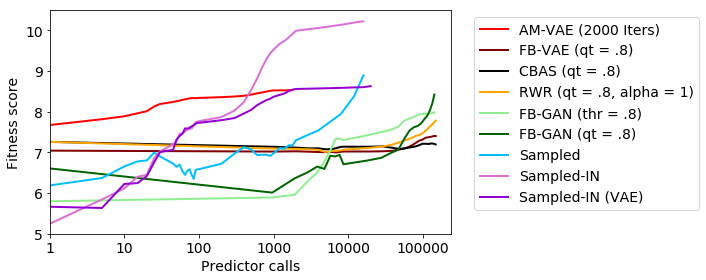

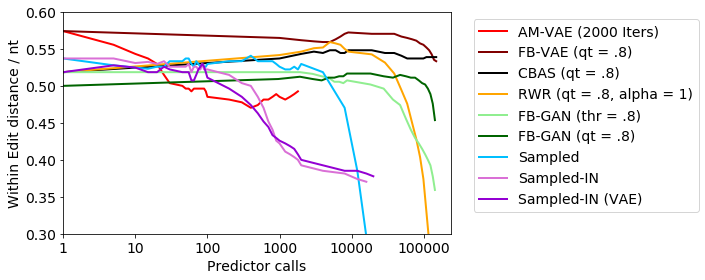

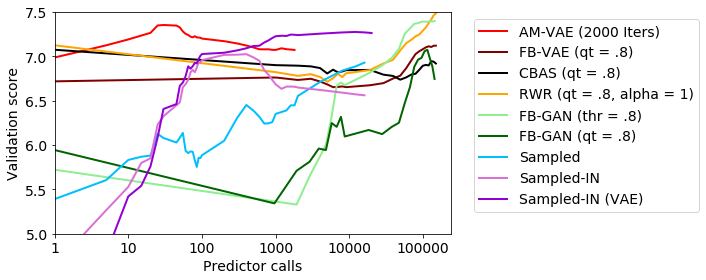

In [137]:
#Plot trajectory data

problem_prefix = "benchmark_optimus"

experiment_suffix = "_traj_comparisons_log"

model_colors = ['red', 'maroon', 'black', 'orange', 'lightgreen', 'darkgreen', 'deepskyblue', 'orchid', 'darkviolet', 'indigo']

figsize = (10, 4)

save_figs = True

predictor_min_y_val = [5.0]
predictor_max_y_val = [10.5]

n_gt_predictors = 1

gt_predictor_min_y_vals = [
    [5.0]
]

gt_predictor_max_y_vals = [
    [7.5]
]

rolling_window = 5

plot_trajectories(
    model_iters,
    model_trajs,
    traj_names,
    [None, None, None, None, None, None, None, None, None, None],
    0,
    'Predictor calls',
    'Fitness score',
    rolling_window=rolling_window,
    colors=model_colors,
    min_x_val=0,
    max_x_val=None,
    min_y_val=predictor_min_y_val[0],
    max_y_val=predictor_max_y_val[0],
    figsize=figsize,
    save_fig=save_figs,
    fig_name=problem_prefix + experiment_suffix + "_fitness_log",
    legend_outside=True,
    log10_scale=True
)

plot_trajectories(
    model_iters,
    model_trajs,
    traj_names,
    [None, None, None, None, None, None, None, None, None, None],
    1,
    'Predictor calls',
    'Within Edit distance / nt',
    rolling_window=rolling_window,
    colors=model_colors,
    min_x_val=0,
    max_x_val=None,
    min_y_val=0.3,
    max_y_val=0.6,
    figsize=figsize,
    save_fig=save_figs,
    fig_name=problem_prefix + experiment_suffix + "_within_edit_distance_log",
    legend_outside=True,
    log10_scale=True
)

for gt_predictor_ix in range(n_gt_predictors) :
    plot_trajectories(
        model_iters,
        model_trajs,
        traj_names,
        [None, None, None, None, None, None, None, None, None, None],
        2 + gt_predictor_ix,
        'Predictor calls',
        'Validation score',
        rolling_window=rolling_window,
        colors=model_colors,
        min_x_val=0,
        max_x_val=None,
        min_y_val=gt_predictor_min_y_vals[0][gt_predictor_ix],
        max_y_val=gt_predictor_max_y_vals[0][gt_predictor_ix],
        figsize=figsize,
        save_fig=save_figs,
        fig_name=problem_prefix + experiment_suffix + "_validation_" + str(gt_predictor_ix) + "_log",
        legend_outside=True,
        log10_scale=True
    )


In [ ]:
#Load sequence trajectories

def load_sequences(file_path, pick_every=1, split_on_tab=True, max_n_sequences=10) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            i = 0
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if i % pick_every == 0 :
                    seqs.append(seq)
                
                i += 1
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        return seqs
    
    except FileNotFoundError :
        return []

model_iters = []
model_seqs = []

for model_i in range(len(traj_dirs)) :
    traj = []
    iter_scale = []
    
    for file_i in file_indexes[model_i] :
        traj_repeats = []
        
        for repeat_suffix in traj_repeat_suffixes[model_i] :
            seqs = load_sequences(traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](file_i), max_n_sequences=10)
            traj_repeats.append(seqs)
        
        traj.append(traj_repeats)
        iter_scale.append(traj_scalefuncs[model_i](file_i))
    
    model_seqs.append(traj)

    iter_scale = np.array(iter_scale)
    model_iters.append(iter_scale)

In [24]:

model_pred_names = ["Optimus 5'", "Optimus 5' (Retrained)"]
model_preds = []

for model_i in range(len(model_seqs)) :
    traj = []
    
    for t in range(len(model_seqs[model_i])) :
        traj_repeats = []
        
        for r in range(len(model_seqs[model_i][t])) :
            seqs = model_seqs[model_i][t][r]
            
            if len(seqs) > 0 :
                score_pred, scores_true, _ = compute_metrics(
                    seqs,
                    None,
                    n_seqs_to_test=len(seqs),
                    batch_size=1,
                    seq_start=0,
                    seq_end=54,
                    opt_len=54
                )

                preds = [score_pred.reshape(-1, 1)] + [score_true.reshape(-1, 1) for score_true in scores_true]

                traj_repeats.append(np.concatenate(preds, axis=1))
            else :
                traj_repeats.append([])
        
        traj.append(traj_repeats)
    
    model_preds.append(traj)


Design Method: am_vae_2000_iters
Scores: [("Optimus 5'", 8.713), ("Optimus 5' (Retrained)", 5.831)]
AGAGAGTGTGTTCTAGTTTGTTTTTCCGTATCTTATTTAAGATTGTAGTTATGG


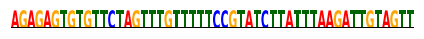

Design Method: fb_vae_qt_8
Scores: [("Optimus 5'", 4.907), ("Optimus 5' (Retrained)", 7.412)]
CTAAGAATGCAGTTATTTCTACTCGGTTTGTTAATATAGTAATCACTATATACG


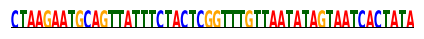

Design Method: cbas_qt_8
Scores: [("Optimus 5'", 7.257), ("Optimus 5' (Retrained)", 3.17)]
CATCCGCAGGGATAGAATTTATATCGTACCCCGGATTATCGATAAAAATCTTGA


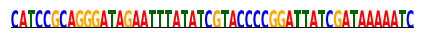

Design Method: rwr_qt_8_alpha_1
Scores: [("Optimus 5'", 7.872), ("Optimus 5' (Retrained)", 7.504)]
CAAAAAAAATAAAAAATAAAAAAAAAAAAAAACAAAAAAAAAAAAAAATAAAAA


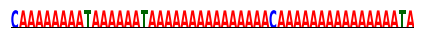

Design Method: fb_gan_thr_8
Scores: [("Optimus 5'", 8.151), ("Optimus 5' (Retrained)", 7.585)]
TCTTTCTTTCTTGTATCGTATCGTTCGTACCTTCTTGTAGTTCTTCTATAATGG


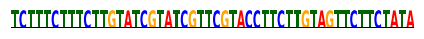

Design Method: fb_gan_qt_8
Scores: [("Optimus 5'", 9.381), ("Optimus 5' (Retrained)", 6.993)]
CTTTGCATTATTTTGTGATGTTTTTGGTTTTTATGATGTTTTTTGTTATGATGG


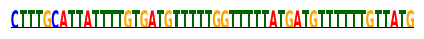

Design Method: sampled
Scores: [("Optimus 5'", 9.913), ("Optimus 5' (Retrained)", 6.907)]
TTGTAATTATTATGATTATTATTATTATGATTATGATGCTTATTATTATTATGG


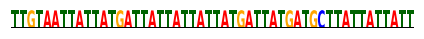

Design Method: sampled_in
Scores: [("Optimus 5'", 10.204), ("Optimus 5' (Retrained)", 6.954)]
ATCTAATAATTATTATGTTTATTATTATAATCAAAATGTTTCGGATTATGATGG


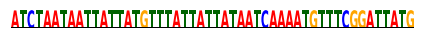

Design Method: sampled_in_vae
Scores: [("Optimus 5'", 8.661), ("Optimus 5' (Retrained)", 7.349)]
CCCGAATTACTAAAATCTTTCCGAAGCTAAAAATGAGAAGAAATAAGATAATGG


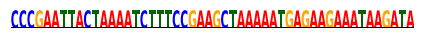

In [28]:
#Plot example sequences per method

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    #fp = FontProperties(family="Ubuntu", weight="bold")
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_simple_seqprop_logo(pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164, save_figs=False, fig_name=None, fig_dpi=300) :

    n_samples = pwm.shape[0]

    #Slice according to seq trim index
    pwm = pwm[:, plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm = np.sum(pwm, axis=0)

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    ax0 = plt.gca()
    plt.sca(ax0)

    plt.axis('off')

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax0, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax0, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax0.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '.png', transparent=True, dpi=fig_dpi)
        plt.savefig(fig_name + '.eps')

    plt.show()


save_figs = True

seq_len = 50
encoder = IdentityEncoder(seq_len, {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    last_ix = len(traj) - 1
    while len(traj[last_ix][0]) <= 0 :
        last_ix -= 1
    
    seq = traj[last_ix][0][0]
    pred = np.round(model_preds[model_i][last_ix][0][0, :].tolist(), 3)
    
    print("Design Method: " + str(traj_name))
    print("Scores: " + str(list(zip(model_pred_names, pred))))
    print(seq)
    
    onehot = np.expand_dims(encoder.encode(seq[:50]), axis=0)
    
    fig_name = traj_name + "example_sequence_0"
    
    plot_simple_seqprop_logo(onehot, sequence_template="N" * seq_len, figsize=(6, 0.65), logo_height=1.0, plot_start=0, plot_end=seq_len, save_figs=save_figs, fig_name=fig_name, fig_dpi=300)
